<a href="https://colab.research.google.com/github/Samiimasmoudii/Deep-Learning-Course/blob/main/FashionMnistLab_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4422102/4422102 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                           

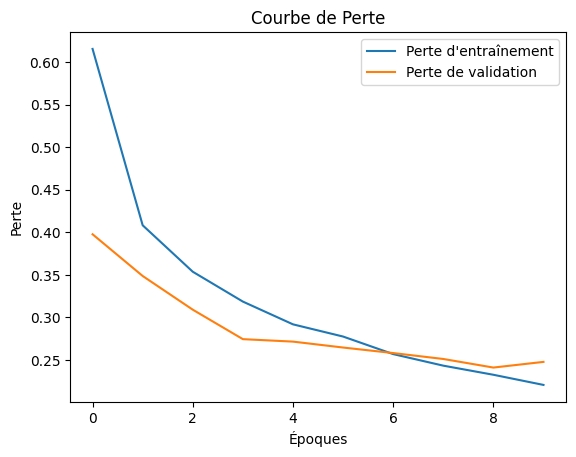

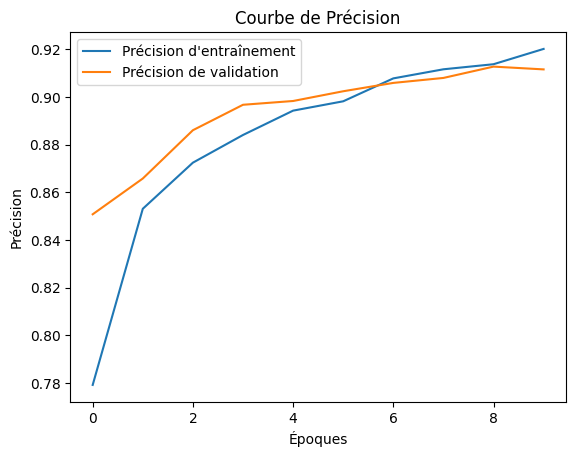

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

# Step 1: Loading and preprocessing the data
# The Fashion MNIST dataset contains 70,000 images of clothing in 10 categories.

# Load the Fashion MNIST data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# The images are grayscale (28x28). Add an extra dimension to match the expected CNN input format (28x28x1).
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0  # Normalize between 0 and 1
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# One-hot encode the labels (example: 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Step 2: Defining the CNN model
# Use the Sequential model to stack layers.

def create_cnn_model():
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Downsampling the image size

    # Second convolutional layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening the features (convert from 2D to 1D)
    model.add(Flatten())

    # Dense (fully connected) layer for learning
    model.add(Dense(128, activation='relu'))  # 128 neurons
    model.add(Dropout(0.5))  # Regularization to prevent overfitting

    # Output layer with softmax for classification into 10 classes
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam',  # Adam optimizer
        loss='categorical_crossentropy',  # Loss function for multi-class classification
        metrics=['accuracy']  # Metric to evaluate performance
    )

    return model

# Create the model
model = create_cnn_model()

# Model summary
model.summary()

# Step 3: Training the model
# Train the model on the training data and evaluate it on the test data.

history = model.fit(
    x_train, y_train,  # Training data
    batch_size=64,  # Number of samples per batch
    epochs=10,  # Number of epochs (complete iterations over the data)
    validation_split=0.2,  # 20% of the training data used for validation
    verbose=1  # Detailed output
)

# Step 4: Evaluation on test data
# This checks the model's accuracy on unseen data.

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy on test data: {test_accuracy:.2f}")

# Step 5: Visualization of training curves (optional)
import matplotlib.pyplot as plt

# Loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [2]:
# Install Keras Tuner if not already installed (uncomment if needed)
!pip install keras-tuner --quiet

# Import Keras Tuner
import keras_tuner as kt

# Redefine the model function to allow hyperparameter tuning
def build_cnn_model(hp):
    model = Sequential()

    # First convolutional layer with tunable filters
    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=16, max_value=64, step=16),  # Tune filters
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(28, 28, 1)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolutional layer with tunable filters
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),  # Tune filters
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Dense layer with tunable units
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),  # Tune dense units
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))  # Tune dropout rate

    # Output layer
    model.add(Dense(10, activation='softmax'))

    # Compile the model with a tunable optimizer
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),  # Tune optimizer
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate the tuner
tuner = kt.Hyperband(
    build_cnn_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_results',
    project_name='fashion_mnist_cnn'
)

# Search for the best hyperparameters
tuner.search(
    x_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    verbose=1
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"""
Optimal number of filters for the first convolutional layer: {best_hps.get('conv_1_filters')}
Optimal number of filters for the second convolutional layer: {best_hps.get('conv_2_filters')}
Optimal number of dense units: {best_hps.get('dense_units')}
Optimal dropout rate: {best_hps.get('dropout_rate')}
Optimal optimizer: {best_hps.get('optimizer')}
""")

# Train the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    verbose=1
)

# Evaluate the best model on test data
test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)
print(f"Précision sur les données de test avec le modèle optimisé : {test_accuracy:.2f}")


Trial 30 Complete [00h 01m 25s]
val_accuracy: 0.9160000085830688

Best val_accuracy So Far: 0.9191666841506958
Total elapsed time: 00h 16m 18s

Optimal number of filters for the first convolutional layer: 64
Optimal number of filters for the second convolutional layer: 128
Optimal number of dense units: 256
Optimal dropout rate: 0.30000000000000004
Optimal optimizer: rmsprop

Epoch 1/10
750/750 [==============================] - 12s 15ms/step - loss: 0.5124 - accuracy: 0.8135 - val_loss: 0.3403 - val_accuracy: 0.8742
Epoch 2/10
750/750 [==============================] - 11s 15ms/step - loss: 0.3225 - accuracy: 0.8820 - val_loss: 0.3063 - val_accuracy: 0.8897
Epoch 3/10
750/750 [==============================] - 11s 14ms/step - loss: 0.2736 - accuracy: 0.8995 - val_loss: 0.2693 - val_accuracy: 0.9011
Epoch 4/10
750/750 [==============================] - 11s 14ms/step - loss: 0.2421 - accuracy: 0.9110 - val_loss: 0.2462 - val_accuracy: 0.9107
Epoch 5/10
750/750 [=========================

In [3]:
# Import Keras Tuner
import keras_tuner as kt

# Define the model-building function for Hyperband
def build_cnn_model(hp):
    model = Sequential()

    # Hyperparameters for the number of filters and units
    model.add(
        Conv2D(
            filters=hp.Choice('conv1_filters', values=[16, 32, 64], default=32),
            kernel_size=(3, 3),
            activation='relu',
            input_shape=(28, 28, 1)
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(
        Conv2D(
            filters=hp.Choice('conv2_filters', values=[32, 64, 128], default=64),
            kernel_size=(3, 3),
            activation='relu'
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    # Dense layer with variable units
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(rate=hp.Choice('dropout_rate', values=[0.3, 0.5, 0.7], default=0.5)))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    # Compile model with adjustable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-3)
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Instantiate the Hyperband tuner
tuner = kt.Hyperband(
    build_cnn_model,
    objective='val_accuracy',  # Optimization metric
    max_epochs=10,             # Maximum number of epochs
    factor=3,                  # Reduction factor for successive halving
    directory='my_dir',        # Directory to save logs
    project_name='fashion_mnist_hyperband'  # Project name
)

# Callback for stopping early
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Perform the hyperparameter search
tuner.search(
    x_train, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of filters for the first conv layer is {best_hps.get('conv1_filters')},
for the second conv layer is {best_hps.get('conv2_filters')},
the number of units in the dense layer is {best_hps.get('dense_units')},
the dropout rate is {best_hps.get('dropout_rate')},
and the optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    x_train, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

# Evaluate on test data
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)
print(f"Test accuracy of the best model: {test_accuracy:.2f}")


Trial 30 Complete [00h 01m 41s]
val_accuracy: 0.8742499947547913

Best val_accuracy So Far: 0.9122499823570251
Total elapsed time: 00h 23m 14s

The optimal number of filters for the first conv layer is 16,
for the second conv layer is 128,
the number of units in the dense layer is 192,
the dropout rate is 0.3,
and the optimal learning rate is 0.001.

Epoch 1/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.5097 - accuracy: 0.8143 - val_loss: 0.3552 - val_accuracy: 0.8712
Epoch 2/10
1500/1500 [==============================] - 11s 8ms/step - loss: 0.3380 - accuracy: 0.8776 - val_loss: 0.3118 - val_accuracy: 0.8825
Epoch 3/10
1500/1500 [==============================] - 11s 8ms/step - loss: 0.2896 - accuracy: 0.8939 - val_loss: 0.2774 - val_accuracy: 0.8957
Epoch 4/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2550 - accuracy: 0.9064 - val_loss: 0.2810 - val_accuracy: 0.8939
Epoch 5/10
1500/1500 [==============================] - 11s 7ms/ste

To refine the model, we conducted hyperparameter tuning using Keras Tuner's Hyperband. This process involved varying parameters such as the number of filters in the convolutional layers, units in the dense layer, dropout rate, and the choice of optimizer (Adam, RMSprop, and SGD). Despite these adjustments, the model's performance consistently resulted in a test accuracy of approximately 0.91, indicating that the architecture is robust and achieves saturation in terms of accuracy for this dataset under the given conditions.

This stability across optimizers and hyperparameters suggests that further improvements may require alternative strategies, such as data augmentation, deeper architectures, or different preprocessing techniques.